# 15. Проверка однородности

In [1]:
import sys
sys.path.append("/Users/PredatoryMink/Statistics")

import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import scipy.optimize as opt
import scipy.special as sp
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm
from mystats.utils import plot as myplot
from mystats.criterion import fit as myfit

### Задание 1

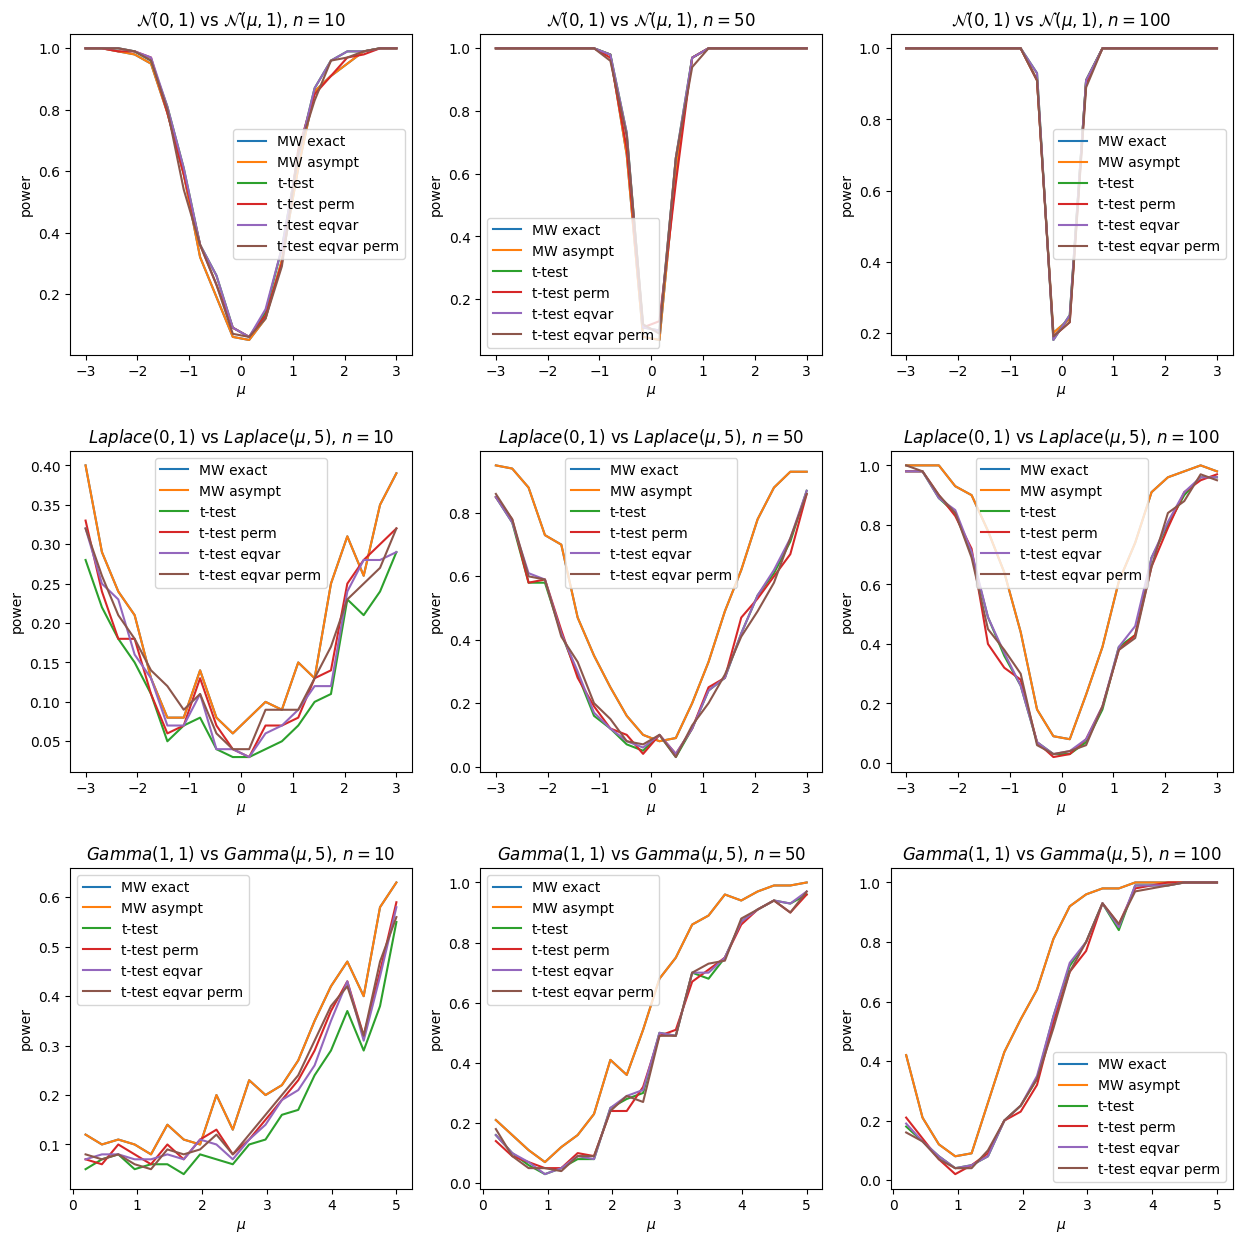

In [2]:
RVs = [(st.norm(0, 1),
        st.norm,
        [{'loc' : mu} for mu in np.linspace(-3, 3, 20)],
        {'scale' : 1},
        r"$\mathcal{N}(0, 1)$ vs $\mathcal{N}(\mu, 1)$"
       ),
       (st.laplace(0, 1),
        st.laplace,
        [{'loc' : mu} for mu in np.linspace(-3, 3, 20)],
        {'scale' : 5},
        r"$Laplace(0, 1)$ vs $Laplace(\mu, 5)$"
       ),
       (st.gamma(1, scale=1),
        st.laplace,
        [(a,) for a in np.linspace(0.2, 5, 20)],
        {'scale' : 5},
        r"$Gamma(1, 1)$ vs $Gamma(\mu, 5)$"
       )]

Ns = [10, 50, 100]
K = 100
alpha = 0.05

num_ax = len(RVs) * len(Ns)

ncols = 3
nrows = num_ax // ncols + (1 if num_ax % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
fig.subplots_adjust(hspace=0.3)
axes = axes.ravel()
ptr = 0

for rv1, dist, grid, const_params, name in RVs:
    for n in Ns:
        ax = axes[ptr]
        ptr += 1
        ax.set_title(fr"{name}, $n = {n}$")
        ax.set_xlabel(r"$\mu$")
        ax.set_ylabel("power")
        res = {"MW exact": [],
               "MW asympt": [],
               "t-test": [],
               "t-test perm": [],
               "t-test eqvar": [],
               "t-test eqvar perm": []}
        for param in grid:
            if type(param) == dict:
                rv2 = dist(**param, **const_params)
            else:
                rv2 = dist(*param, **const_params)
            x = rv1.rvs((K, n))
            y = rv2.rvs((K, n))
            
            pval = st.mannwhitneyu(x, y, axis=1, method='exact').pvalue
            power = (pval < alpha).mean()
            res["MW exact"].append(power)
            
            pval = st.mannwhitneyu(x, y, axis=1, method='asymptotic').pvalue
            power = (pval < alpha).mean()
            res["MW asympt"].append(power)

            pval = st.ttest_ind(x, y, axis=1, equal_var=False, permutations=None).pvalue
            power = (pval < alpha).mean()
            res["t-test"].append(power)
            
            pval = st.ttest_ind(x, y, axis=1, equal_var=False, permutations=100).pvalue
            power = (pval < alpha).mean()
            res["t-test perm"].append(power)
            
            pval = st.ttest_ind(x, y, axis=1, equal_var=True, permutations=None).pvalue
            power = (pval < alpha).mean()
            res["t-test eqvar"].append(power)
            
            pval = st.ttest_ind(x, y, axis=1, equal_var=True, permutations=100).pvalue
            power = (pval < alpha).mean()
            res["t-test eqvar perm"].append(power)

        if type(param) == dict:
            xs = [list(d.values())[0] for d in grid]
        else:
            xs = [d[0] for d in grid]
        for cr, power in res.items():
            ax.plot(xs, power, label=cr)
        ax.legend();

### Задание 2

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 190.87it/s]


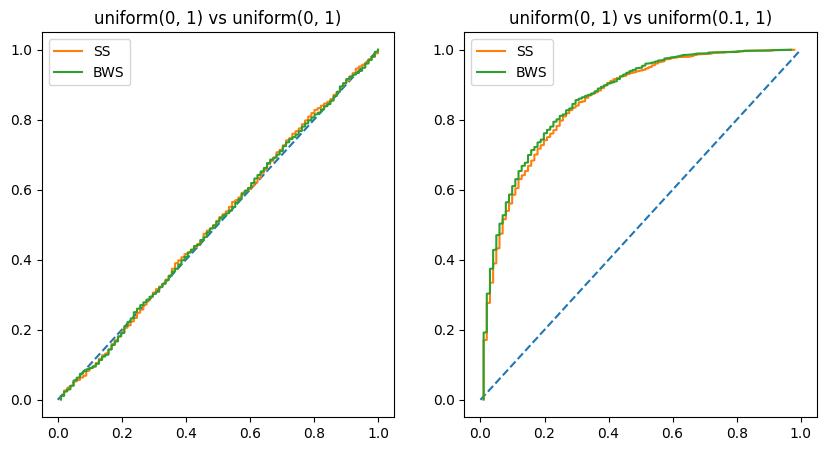

In [3]:
K = 1_000
N = 50
RVs = [(st.uniform(0, 1), st.uniform(0, 1)),
       (st.uniform(0, 1), st.uniform(0.1, 1))]

num_ax = len(RVs)

ncols = 2
nrows = num_ax // ncols + (1 if num_ax % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
fig.subplots_adjust(hspace=0.3)

for (rv1, rv2), ax in zip(RVs, axes.ravel()):
    ax.set_title(f"{rv1.dist.name}{rv1.args} vs {rv2.dist.name}{rv2.args}")
    ax.plot([0, 1], [0, 1], ls='dashed')
    
    Y = rv1.rvs((K, N))
    Z = rv2.rvs((K, N))
    pval = {"SS": np.zeros(K),
            "BWS": np.zeros(K)}
    for i in tqdm(range(K)):
        method = st.PermutationMethod(n_resamples=100)
        pval["SS"][i] = st.anderson_ksamp((Y[i], Z[i]), method=method).pvalue
        pval["BWS"][i] = st.bws_test(Y[i], Z[i], method=method).pvalue
    
    for name, p in pval.items():
        myplot.ecdf(p, ax=ax, label=name)
    ax.legend();

### Задание 3

In [4]:
class IrwinHall:
    def __init__(self, n, a=0, b=1, centered_scaled=False):
        self.n = n
        self.un = st.uniform(a, b - a)
        self.cs = centered_scaled
        self.args = (n, a, b, centered_scaled)
        self.un.dist.name = "IrwinHall"
        self.dist = self.un.dist

    def rvs(self, shape=None):
        uni = self.un.rvs((*shape, self.n))
        res = uni.sum(axis=-1)
        if self.cs:
            res = (res - self.n * self.un.mean()) / mt.sqrt(self.n * self.un.var())
        return res

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.53it/s]


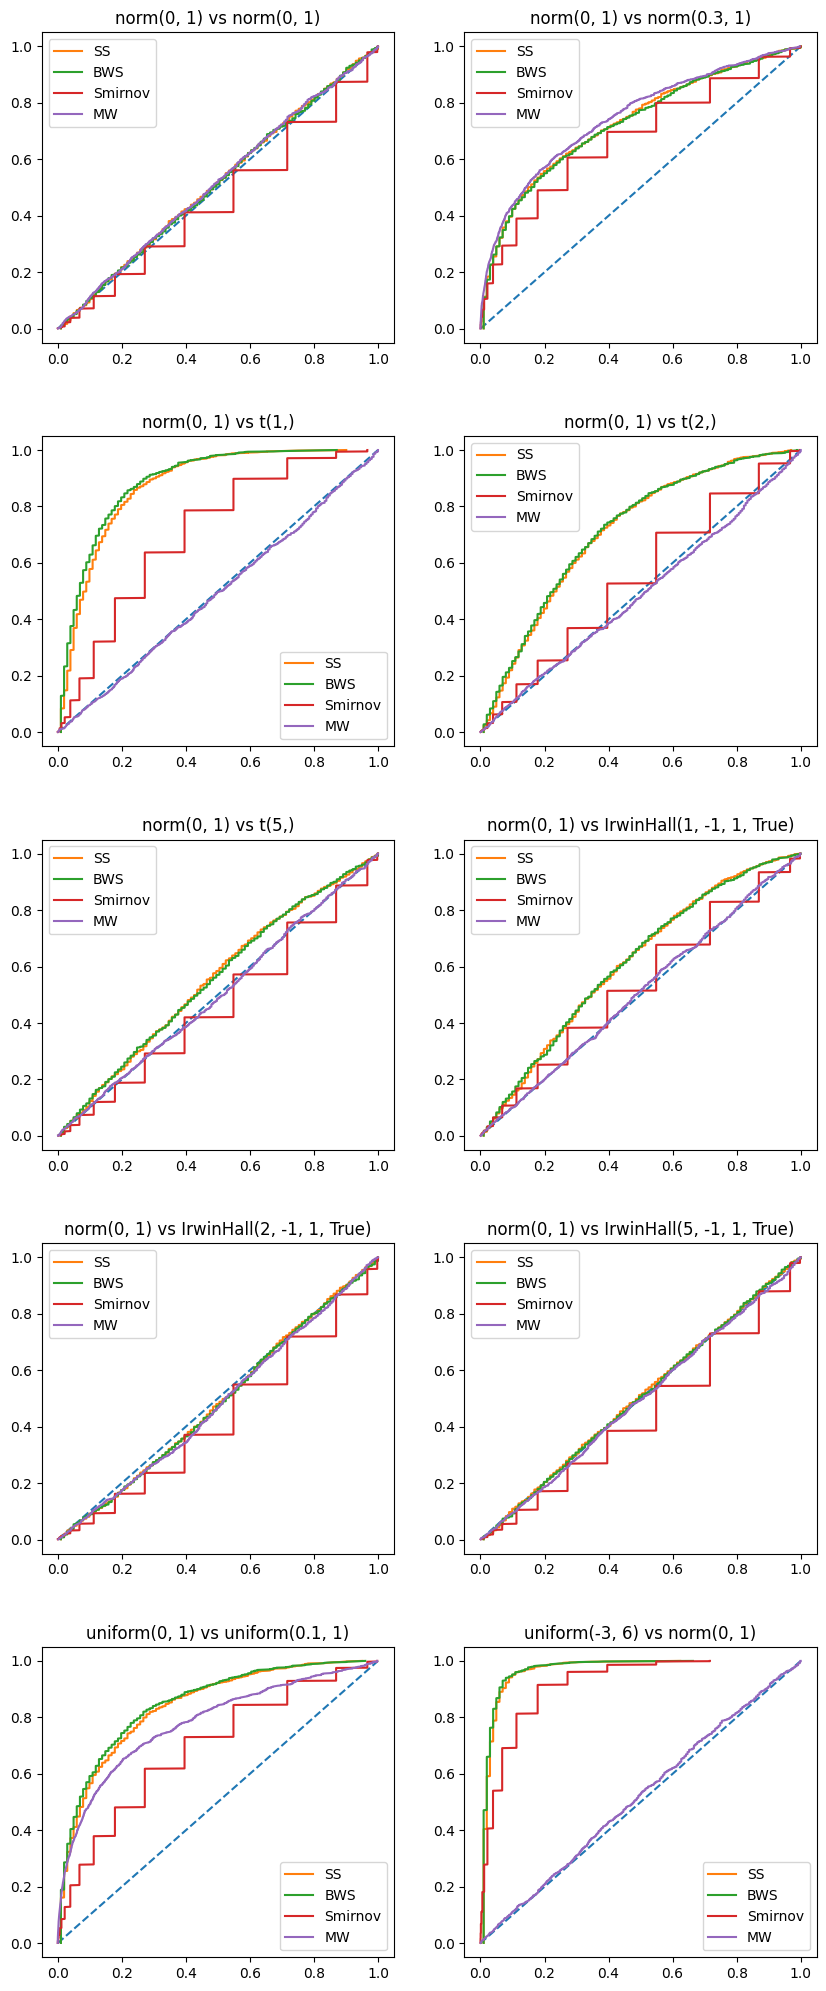

In [5]:
K = 1_000
N = 50
RVs = [(st.norm(0, 1), st.norm(0, 1)),
       (st.norm(0, 1), st.norm(0.3, 1))] + [
       (st.norm(0, 1), st.t(k)) for k in [1, 2, 5]] + [
       (st.norm(0, 1), IrwinHall(k, -1, 1, True)) for k in [1, 2, 5]] + [
       (st.uniform(0, 1), st.uniform(0.1, 1)),
       (st.uniform(-3, 6), st.norm(0, 1))]

num_ax = len(RVs)

ncols = 2
nrows = num_ax // ncols + (1 if num_ax % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
fig.subplots_adjust(hspace=0.3)

for (rv1, rv2), ax in zip(RVs, axes.ravel()):
    ax.set_title(f"{rv1.dist.name}{rv1.args} vs {rv2.dist.name}{rv2.args}")
    ax.plot([0, 1], [0, 1], ls='dashed')
    
    Y = rv1.rvs((K, N))
    Z = rv2.rvs((K, N))
    pval = {"SS": np.zeros(K),
            "BWS": np.zeros(K)}
    pval["Smirnov"] = st.ks_2samp(Y, Z, axis=1).pvalue
    pval["MW"] = st.mannwhitneyu(Y, Z, axis=1).pvalue
    for i in tqdm(range(K)):
        method = st.PermutationMethod(n_resamples=100)
        pval["SS"][i] = st.anderson_ksamp((Y[i], Z[i]), method=method).pvalue
        pval["BWS"][i] = st.bws_test(Y[i], Z[i], method=method).pvalue
    
    for name, p in pval.items():
        myplot.ecdf(p, ax=ax, label=name)
    ax.legend();

### Задание 4

In [6]:
def chi2_test(samp):
    k = len(samp)
    merged = np.zeros(0)
    for x in samp:
        merged = np.r_[merged, x]
    merged = np.sort(merged)
    n = merged.size
    num_of_bins = max(3, int(max(mt.log(n, 2), n ** 0.2)))
    gsize = n // num_of_bins
    bins = merged[gsize : -gsize + 1 : gsize]
    f_obs = np.zeros((k, num_of_bins), int)
    for i, x in enumerate(samp):
        f_obs[i] = np.bincount(np.digitize(x, bins), minlength=num_of_bins)
    p_value = st.chi2_contingency(f_obs).pvalue
    return p_value

100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 111.78it/s]


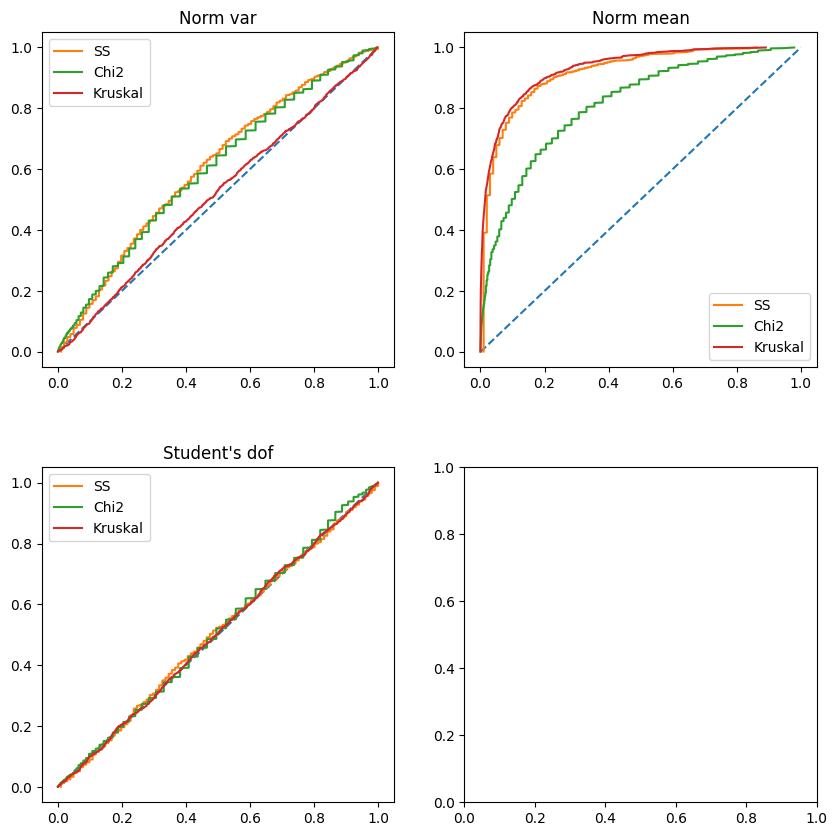

In [7]:
K = 1_000
N = 30
RVs = [([st.norm(0, mt.sqrt(3 + i)) for i in range(4)], "Norm var"),
       ([st.norm(i / 4, 1) for i in range(1, 5)], "Norm mean"),
       ([st.t(4 + i) for i in range(4)], "Student's dof")]

num_ax = len(RVs)

ncols = 2
nrows = num_ax // ncols + (1 if num_ax % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
fig.subplots_adjust(hspace=0.3)

for (variables, title), ax in zip(RVs, axes.ravel()):
    ax.set_title(title)
    ax.plot([0, 1], [0, 1], ls='dashed')
    
    n_samples = len(variables)
    pval = {"SS": np.zeros(K),
            "Chi2": np.zeros(K),
            "Kruskal": np.zeros(K)}
    for i in tqdm(range(K)):
        samples = []
        for rv in variables:
            samples.append(rv.rvs(N))
        method = st.PermutationMethod(n_resamples=100)
        pval["SS"][i] = st.anderson_ksamp(samples, method=method).pvalue
        pval["Kruskal"][i] = st.kruskal(*samples).pvalue
        pval["Chi2"][i] = chi2_test(samples)
    
    for name, p in pval.items():
        myplot.ecdf(p, ax=ax, label=name)
    ax.legend();